In [1]:
# a simple neural network implementation

import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class NeuralNetwork(object):
    
    def __init__(self):
        self.inputLayerSize = 2
        self.hiddenLayerSize = 3
        self.outputLayerSize = 1
        
        # bit different than standard convention
        self.w1 = np.random.randn(self.inputLayerSize, self.hiddenLayerSize) # weight vector going from input layer to hidden layer
        self.w2 = np.random.randn(self.hiddenLayerSize, self.outputLayerSize) # weight vector going from hidden layer to output layer
    
    def sigmoid(self, z):
        """
        Sigmoid activation function σ --> 1/(1+exp(-z))
        :param z: input vector
        :return: sigmoid activation vector
        """
        return 1.0/(1+np.exp(-z))
    
    def sigmoid_prime(self, z):
        """
        Derivative of sigmoid σ' --> σ * (1 - σ)
        https://math.stackexchange.com/questions/78575/derivative-of-sigmoid-function-sigma-x-frac11e-x
        :param z: input vector
        :return: derivative vector of sigmoid
        """
        return self.sigmoid(z) * (1 - self.sigmoid(z))
    
    def forward(self, X):
        """
        Forward propogation of input X
        :param X: input vector of size (number of examples x number of features)
        :return: vector of predicted output
        """
        self.z2 = np.dot(X, self.w1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.w2)
        return self.sigmoid(self.z3) # predicted output
    
    def cost_function(self, X, y):
        """
        Quadratic cost/loss function - MSE
        :param X: input feature vector
        :param y: true output vector
        :return: cost vector
        """
        self.a3 = self.forward(X)
        J = (sum((y-self.a3)**2))/2
        return J
    
    def cost_function_prime(self, X, y):
        """
        Compute derivative of cost function w.r.t. hyperparameters/weights
        :param X: input feature vector
        :param y: true output vector
        :return: derivative vector
        """
        self.a3 = self.forward(X)
        
        # 𝛿3 -> ∂J/∂a3 * ∂a3/∂z3
        delta3 = -(y-self.a3) * self.sigmoid_prime(self.z3)
        # ∂J/∂W3 -> a2.𝛿3 
        dJdw2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.w2.T) * self.sigmoid_prime(self.z2)
        dJdw1 = np.dot(X.T, delta2)
        
        return dJdw1, dJdw2
    
    def get_params(self):
        """
        Helper function for scipy optimizer.
        Concatenate all the parameters into a single vector
        """
        return np.concatenate((self.w1.ravel(), self.w2.ravel()))
    
    def set_params(self, params):
        """
        Helper function for scipy optimizer.
        Un-concatenate and set parameters
        """
        start = 0
        w1_end = self.inputLayerSize * self.hiddenLayerSize
        self.w1 = np.reshape(params[0:w1_end], (self.inputLayerSize, self.hiddenLayerSize))
        w2_end = w1_end + self.hiddenLayerSize*self.outputLayerSize
        self.w2 = np.reshape(params[w1_end:w2_end], (self.hiddenLayerSize, self.outputLayerSize))
    
    def compute_gradients(self, X, y):
        """
        Gradients for scipy optimizer
        """
        dJdw1, dJdw2 = self.cost_function_prime(X, y)
        return np.concatenate((dJdw1.ravel(), dJdw2.ravel()))

In [3]:
X = np.array(([3,5],[5,1],[10,2]), dtype=float) # (hours sleeping, hours studying)
y = np.array(([75],[82],[93]), dtype=float) # score on a test

# normalize
X = X/np.amax(X, axis=0)
y = y/100

nn = NeuralNetwork()

cost0 = nn.cost_function(X, y)
print('Initial cost: ', cost0)

for i in range(10):
    dJdw1, dJdw2 = nn.cost_function_prime(X, y)
    nn.w1 = nn.w1 - 2.0*dJdw1
    nn.w2 = nn.w2 - 2.0*dJdw2
    print(nn.cost_function(X,y))

Initial cost:  [ 0.05853627]
[ 0.04410129]
[ 0.03422622]
[ 0.0273355]
[ 0.02243495]
[ 0.0188866]
[ 0.01627366]
[ 0.01431883]
[ 0.01283439]
[ 0.01169105]
[ 0.01079838]


In [4]:
class Optimizer(object):
    
    def __init__(self, NN):
        """
        Takes NeuralNetwork object on which to optimize
        """
        self.NN = NN
    
    def backprop(self, X, y, eta=2, epochs=100, disp=False, plot=True):
        """
        Given X,y train the network using using backprop
        :param X: input feature vector
        :param y: true output vector
        :param eta: learning rate
        :param epochs: number of iterations
        :param display: if true print the cost/epoch
        :param plot: plot cost w.r.t. iteration
        """
        self.costs = []
        for i in range(1, epochs+1):
            dJdw1, dJdw2 = self.NN.cost_function_prime(X, y)
            self.NN.w1 -= eta * dJdw1
            self.NN.w2 -= eta * dJdw2
            J = self.NN.cost_function(X, y)
            self.costs.append(J)
            if display and i%5 == 0: 
                print('Epoch {i}/{epochs} ===========> cost: {J}'.format(i=i, epochs=epochs, J=J))
        if plot:
            plt.plot(opt.costs)
            plt.grid(1)
            plt.xlabel('Iterations')
            plt.ylabel('Cost')
    
    # using scipy optimizer (BFGS)
    def callback_func(self, params):
        self.NN.set_params(params)
        self.J.append(self.NN.cost_function(self.X, self.y))
    
    def cost_function_wrapper(self, params, X, y):
        self.NN.set_params(params)
        cost = self.NN.cost_function(X, y)
        grad = self.NN.compute_gradients(X, y)
        return cost, grad
    
    def BFGS(self, X, y, epochs=100, disp=False, plot=True):
        """
        Given X, y train the network using BFGS optimization method
        """
        self.X = X
        self.y = y
        self.J = []
        
        initial_params = self.NN.get_params()
        
        options = {'maxiter': epochs, 'disp': disp}
        _res = optimize.minimize(self.cost_function_wrapper, initial_params, jac=True, method='BFGS', args=(X, y), options=options, callback=self.callback_func)
        self.NN.set_params(_res.x)
        self.optimizationResults = _res
        if plot:
            plt.plot(self.J)
            plt.grid(1)
            plt.xlabel('Iterations')
            plt.ylabel('Cost')

Epoch 5/100 ===========> cost: [ 0.01373461]
Epoch 10/100 ===========> cost: [ 0.01194403]
Epoch 15/100 ===========> cost: [ 0.01155443]
Epoch 20/100 ===========> cost: [ 0.01135767]
Epoch 25/100 ===========> cost: [ 0.01119879]
Epoch 30/100 ===========> cost: [ 0.01105069]
Epoch 35/100 ===========> cost: [ 0.01090793]
Epoch 40/100 ===========> cost: [ 0.0107692]
Epoch 45/100 ===========> cost: [ 0.01063408]
Epoch 50/100 ===========> cost: [ 0.01050229]
Epoch 55/100 ===========> cost: [ 0.01037361]
Epoch 60/100 ===========> cost: [ 0.01024783]
Epoch 65/100 ===========> cost: [ 0.01012476]
Epoch 70/100 ===========> cost: [ 0.01000422]
Epoch 75/100 ===========> cost: [ 0.00988604]
Epoch 80/100 ===========> cost: [ 0.00977006]
Epoch 85/100 ===========> cost: [ 0.00965613]
Epoch 90/100 ===========> cost: [ 0.00954409]
Epoch 95/100 ===========> cost: [ 0.00943382]
Epoch 100/100 ===========> cost: [ 0.00932517]


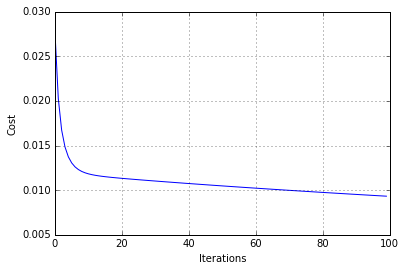

In [5]:
nn = NeuralNetwork()
opt = Optimizer(nn)
opt.backprop(X, y, disp=True)

Optimization terminated successfully.
         Current function value: 0.001226
         Iterations: 39
         Function evaluations: 44
         Gradient evaluations: 44


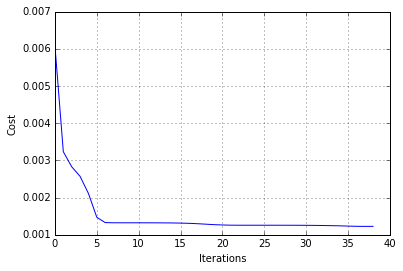

In [6]:
opt.BFGS(X, y, disp=True)